# Consistency Models for Posterior Estimation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

In this notebook, we use Consistency Models (CMs) as a plug-in replacement to obtain posterior samples with fewer sampling steps.

CMs can be trained in two ways: First, they can be used to _distill_ an existing score-based diffusion model, thereby massively decreasing the sampling time at the expense of an additional training phase. Second, they can be trained from scratch using a procedure named _Consistency Training_. For now, we only support the latter.

## Background<a class="anchor" id="background"></a>

Consistency Models [1] leverage some nice properties of score-based diffusion to enable few-step sampling. Score-based diffusion initially relied on a stochastic differential equation (SDE) for sampling, but there is also a ordinary (non-stochastic) differential equation (ODE) has the same _marginal_ distribution at each time step $t$ [2]. This means that even though SDE and ODE produce different paths from the noise distribution to the target distribution, the resulting distributions when looking at many paths at time $t$ is the same. The ODE is also called Probability Flow ODE.

CMs now leverage the fact that there is no randomness in the ODE formulation. That means, if you start at a certain point in the latent space, you will always take the same path and always end up at the same point in the data space. The same is true for every point on the path: if you integrate to get to time $t=0$, you will end up at the same point as well. In short: for each path, there is exactly one corresponding point in latent space (at $t=T$) and one corresponding point in data space (at $t=0$). The goal of CMs is now the following: each point at a time point $t$ belongs to exactly one path, and we want to predict where this path will end up at $t=0$. The function that does this is called the _consistency function_ $f$. If we have the correct function for all $t\in(0,T]$, we can just sample from the latent distribution ($t=T$) and use $f$ to directly map to the corresponding point at $t=0$, which is in the target distribution. So for sampling from the target distribution, we avoid any integration and only need one evaluation of the consistency function. In practice, the one-step sampling does not work very well. Instead, we leverage a multi-step sampling method where we call $f$ multiple times. Please check out the [1] for more background on this sampling procedure.

When only reading the above you might wonder why we also learn the mapping to $t=0$ of all intermediate time steps, and not only for $T=0$. The main answer is that for efficient training, we do not want to actually compute the two associated points explicitly. Doing so would require to do a precise integration at training time, which is often not feasible as it is too computationally costly. Learning all time steps opens up the possibility for a different training approach where we can avoid this.

The details of this become a bit more complicated, and we advise you to take a look at [1] if you are interested in a more thorough and mathematical discussion. Here we will give a rough description of the underlying concepts.

First, we know that at $t=0$, it holds that $f(x,t=0)=x$, as $x$ is part of the path that ends at $x$. This _boundary condition_ serves as an "anchor" for our training, this is the information that the network knows at the start of the training procedure (we encode it with a time-dependent skip-connection, so the network is forced to be the identity function at $t=0$).

For training, we now somehow have to propagate this information to the rest of the part. The basic idea for this is simple. We just take a point $x_1$ closer to the data distribution (smaller time $t_1$) and intergrate for a small time step $dt$ to a point $x_2$ on the same path that is closer to the latent distribution (larger time $t_2=t_1+dt$). As we know that for $t=0$ our network provides the correct output for our path, we want to propagate the information from smaller times to larger times. Our training goal is to move the output of $f(x_2, t=t_2)$ towards the output of $f(x_1, t=t_1)$. How to choose $x_1$, $t_1$ and $dt$ is an empirical question, see the [1] for some reasoning on what works.

In the case of _distillation_, we start with a trained score-based diffusion model. We can use it to integrate the Probability Flow ODE to get from $x_1$ to $x_2$. If we do not have such a model, it seems as if we were stuck. We do not know which points lie on the same path, so we do not know which outputs to make similar. Fortunately, it turns out that there is an _unbiased approximator_ that, if averaged over many samples (check out the paper for the exact description), will also give us the correct score. If we use this approximator instead of the score model, and use only a single Euler step to move along the path, we get an algorithm similar to the one described for distillation. It is called Consistency Training (CT) and allows us to train a consistency model using only samples from the data distribution. The algorithm for this was improved a lot in [3], and we have incorporated those improvements into our implementation.

As we have made several approximations to get there, how we have to choose our hyperparameters unfortunately becomes quite unintuitive. We have to rely on empirical observations to see what works. This was done in [4], we encourage you to use the values provided there as starting points. If you happen to find hyperparameters that work significantly better, please let us know. This will help others to find the correct region in the hyperparameter space.

To make this work for simulation-based inference, we can make the whole process conditional, so we can produce conditional distributions as well. Below, you can see a conceptual visualization of posterior estimation with CMs.

![Visualization of the way consistency models map from the path to the end point in the data distribution. Depicts the concepts described in the main text.](https://arxiv.org/html/2312.05440v2/extracted/5435837/figures/cmpe_main.png)

### References

[1] Song, Y., Dhariwal, P., Chen, M., & Sutskever, I. (2023). Consistency Models. *arXiv preprint*. [https://doi.org/10.48550/arXiv.2303.01469](https://doi.org/10.48550/arXiv.2303.01469)

[2] Song, Y., Sohl-Dickstein, J., Kingma, D. P., Kumar, A., Ermon, S., & Poole, B. (2021). Score-Based Generative Modeling through Stochastic Differential Equations. In _International Conference on Learning Representations_. [https://openreview.net/forum?id=PxTIG12RRHS](https://openreview.net/forum?id=PxTIG12RRHS)

[3] Song, Y., & Dhariwal, P. (2023). Improved Techniques for Training Consistency Models. *arXiv preprint*. [https://doi.org/10.48550/arXiv.2310.14189](https://doi.org/10.48550/arXiv.2310.14189)

[4] Schmitt, M., Pratz, V., Köthe, U., Bürkner, P.-C., & Radev, S. T. (2024). Consistency Models for Scalable and Fast Simulation-Based Inference. *arXiv preprint*. [https://doi.org/10.48550/arXiv.2312.05440](https://doi.org/10.48550/arXiv.2312.05440)

## Simulator: Two Moons<a class="anchor" id="simulator"></a>

We will use the Concistency Model as a plug-in replacement for Flow Matching. Refer to the tutorial "Two moons toy example with flow matching" for more details on this simulator.

In [2]:
simulator = bf.benchmarks.simulators.TwoMoons()

We generate some data to see what the simulator does:

In [3]:
# generate 64 random draws from the joint distribution p(r, alpha, theta, x)
sample_data = simulator.sample((64,))

In [4]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['parameters', 'observables'])
Types of sample_data values:
	 {'parameters': <class 'numpy.ndarray'>, 'observables': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'parameters': (64, 2), 'observables': (64, 2)}


## Data Adapter

The next step is to tell BayesFlow how to deal with the simulated variables. You may also think of this as informing BayesFlow about the data flow, i.e., which variables go into which network.

For this example, we want to learn the posterior distribution $p(\theta | x)$, so we **infer** $\theta$, **conditioning** on $x$. In the output from the last command, we see that the simulator provides $\theta$ as `"parameters"` and $x$ as `"observables"`.

In [5]:
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["parameters"],
    inference_conditions=["observables"],
)

## Dataset
For this example, we will sample our training data ahead of time and use offline training with a `bf.datasets.OfflineDataset`.

In [6]:
batch_size = 64
num_training_batches = 512
num_validation_batches = 128

In [7]:
training_samples = simulator.sample((num_training_batches * batch_size,))
validation_samples = simulator.sample((num_validation_batches * batch_size,))

In [8]:
training_dataset = bf.datasets.OfflineDataset(training_samples, batch_size=batch_size, data_adapter=data_adapter)
validation_dataset = bf.datasets.OfflineDataset(validation_samples, batch_size=batch_size, data_adapter=data_adapter)

## Training a neural network to approximate all posteriors

The next step is to set up the neural network that will approximate the posterior $p(\theta|x)$.

Consistency models use _scheduling functions_ to adjust some of the hyperparameters, for example the time discretization during training. Consequently, we have to specify the total number of training steps (_gradient updates_) before the start of the training.
For offline training with a given number of epochs, we can calculate it as below:

In [9]:
epochs = 30
total_steps = epochs * num_training_batches

Apart from the usual parameters like learning rate and batch size, CMs come with a number of different hyperparameters. Unfortunately, they can heavily interact, so they can be hard to tune. The main hyperparameters are:

- Maximum time `max_time`: This also serves as the standard deviation of the latent distribution.  You can experiment with this, values from 10-200 seem to work well. In any case, it should be larger than the standard deviation of the target distribution.
- Minimum/maximum number of discretization steps during training `s0`/`s1`: The effect of those is hard to grasp. 10 works well for `s0`. Intuitively, increasing `s1` along with the number of epochs should lead to better result, but in practice we sometimes observe a breakdown for high values of `s1`. This seems to be problem-dependent, so just try it out.
- `sigma2` modifies the time-dependency of the skip connection. Its effect on the training is unclear, we recommend leaving it at 1.0 or setting it to the approximate variance of the target distribution.
- Smallest time value `eps` ($t=\epsilon$ is used instead of $t=0$ for numerical reasons): No large effect, as long as it is kept small enough. Probably not worth tuning.

In [10]:
inference_network = bf.networks.ConsistencyModel(
    subnet="mlp",
    subnet_kwargs=dict(
        depth=6,
        width=256,
    ),
    total_steps = total_steps
)

This inference network is just a general CM architecture, not yet adapted to the specific inference task at hand (i.e., posterior appproximation). To achieve this adaptation, we combine the network with our data adapter, which together form an `approximator`. In this case, we need a `ContinuousApproximator` since the target we want to approximate is the posterior of the *continuous* parameter vector $\theta$.

In [11]:
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

### Optimizer and Learning Rate

We use an Adam optimizer with [cosine decay](https://keras.io/api/optimizers/learning_rate_schedules/cosine_decay/) to decrease the learning rate towards zero over the training time. 

In [12]:
initial_learning_rate = 5e-4
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    total_steps,
)

optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)

In [13]:
approximator.compile(optimizer=optimizer)

### Training

We are ready to train our deep posterior approximator on the two moons example. We pass the dataset object to the `fit` method and watch as Bayesflow trains.

In [14]:
history = approximator.fit(
    epochs=epochs,
    dataset=training_dataset,
    validation_data=validation_dataset,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.3707 - loss/inference_loss: 0.3707 - val_loss: 0.3482 - val_loss/inference_loss: 0.3482
Epoch 2/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3199 - loss/inference_loss: 0.3199 - val_loss: 0.3060 - val_loss/inference_loss: 0.3060
Epoch 3/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3031 - loss/inference_loss: 0.3031 - val_loss: 0.2138 - val_loss/inference_loss: 0.2138
Epoch 4/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2939 - loss/inference_loss: 0.2939 - val_loss: 0.2869 - val_loss/inference_loss: 0.2869
Epoch 5/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2921 - loss/inference_loss: 0.2921 - val_loss: 0.3400 - val_loss/inference_loss: 0.3400
Epoch 6/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2898 - loss/inference_loss: 0.2898 - val_loss: 0.2698 - val_loss/inference_loss: 0.2698
Epoch 7/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2862 - loss/inference_loss: 0.2862 - v

## Validation

### Two Moons Posterior

The two moons posterior at point $x = (0, 0)$ should resemble two crescent shapes. Below, we plot the corresponding posterior samples and posterior density. 

These results suggest that our flow matching setup can approximate the expected analytical posterior well. You can achieve an even better fit if you use online training, more epochs, or better hyperparameters.

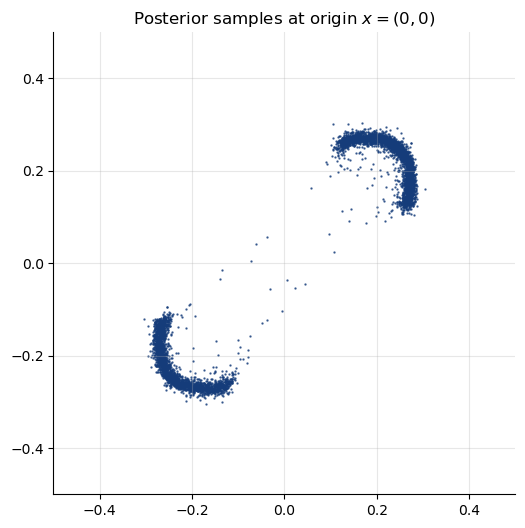

In [16]:
# Set the number of posterior draws you want to get
num_samples = 5000

# Obtain samples from amortized posterior
conditions = {"observables": np.array([[0.0, 0.0]]).astype("float32")}
samples_at_origin = approximator.sample(conditions=conditions, num_samples=num_samples)["parameters"]

# Prepare figure
f, axes = plt.subplots(1, figsize=(6, 6))

# Plot samples
axes.scatter(samples_at_origin[0, :, 0], samples_at_origin[0, :, 1], color="#153c7a", alpha=0.75, s=0.5)
sns.despine(ax=axes)
axes.set_title(r"Posterior samples at origin $x=(0, 0)$")
axes.grid(alpha=0.3)
axes.set_aspect("equal", adjustable="box")
axes.set_xlim([-0.5, 0.5])
_ = axes.set_ylim([-0.5, 0.5])

The posterior looks as we have expected in this case. However, in general, we do not know how the posterior is supposed to look like for any specific dataset. As such, we need diagnostics that validate the correctness of the inferred posterior. One such diagnostic is simulation-based calibration(SBC), which we can apply for free due to amortization. For more details on SBC and diagnostic plots, see:

1. Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018). Validating Bayesian inference algorithms with simulation-based calibration. *arXiv preprint*.
2. Säilynoja, T., Bürkner, P. C., & Vehtari, A. (2022). Graphical test for discrete uniformity and its applications in goodness-of-fit evaluation and multiple sample comparison. *Statistics and Computing*.